In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
sc = spark.sparkContext

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

# LAB1

In [ ]:
import urllib.request

In [ ]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7f08dadd6710>)

In [ ]:
lines = sc.textFile("apache_logs")

## Zad 1
Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

In [ ]:
import re

In [ ]:
regex_web = r'https?://(:?www.|)(.*?)(/|\")|\"-\"'

In [ ]:
lines = sc.textFile("apache_logs")

In [ ]:
domains = lines.map(lambda s: (re.search(regex_web, s).group(2), 1))
domains = domains.filter(lambda s: s[0])
domains = domains.filter(lambda s: 'semicomplete.com' not in s[0])

In [ ]:
domainsCount = domains.reduceByKey(lambda a, b: a + b)

In [ ]:
topdomains = domainsCount.takeOrdered(10, lambda pair: -pair[1])

In [ ]:
topdomains

[('google.com', 228),
 ('s-chassis.co.nz', 51),
 ('google.fr', 46),
 ('google.co.uk', 37),
 ('stackoverflow.com', 34),
 ('google.de', 31),
 ('logstash.net', 31),
 ('google.es', 29),
 ('google.co.in', 25),
 ('tuxradar.com', 12)]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(topdomains, columns=['Domain', 'Count'])
df

,Domain,Count
0,google.com,228
1,s-chassis.co.nz,51
2,google.fr,46
3,google.co.uk,37
4,stackoverflow.com,34
5,google.de,31
6,logstash.net,31
7,google.es,29
8,google.co.in,25
9,tuxradar.com,12


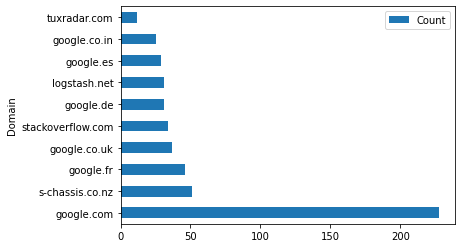

In [ ]:
df.plot.barh(x = 'Domain')

I omitted "-" domain as it carries only information that users made requests to domain not known by us, but it is worth to mention that those are most of requests

## Zad 2
Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc)

In [ ]:
time_regex = r'\[\d+/\w+/\d+:(\d+):'
code_regex = r'(GET|POST|HEAD|OPTIONS).*?\" (\d+)'

In [ ]:
data = lines.map(lambda s: ((re.search(time_regex, s).group(1), re.search(code_regex, s).group(2)), 1))

In [ ]:
data.collect()

In [ ]:
data_reduced = data.reduceByKey(lambda a, b: a + b) \
  .map(lambda a: [a[0][0], a[0][1], a[1]] )

In [ ]:
data_reduced.takeOrdered(10)

[['00', '200', 333],
 ['00', '301', 12],
 ['00', '304', 10],
 ['00', '404', 6],
 ['01', '200', 313],
 ['01', '206', 4],
 ['01', '304', 33],
 ['01', '404', 10],
 ['02', '200', 347],
 ['02', '301', 2]]

In [ ]:
preped_data = data_reduced.collect()

In [ ]:
import seaborn as sns

In [ ]:
df = pd.DataFrame(
    data=preped_data,
    columns=["hour", "code", "count"]
)

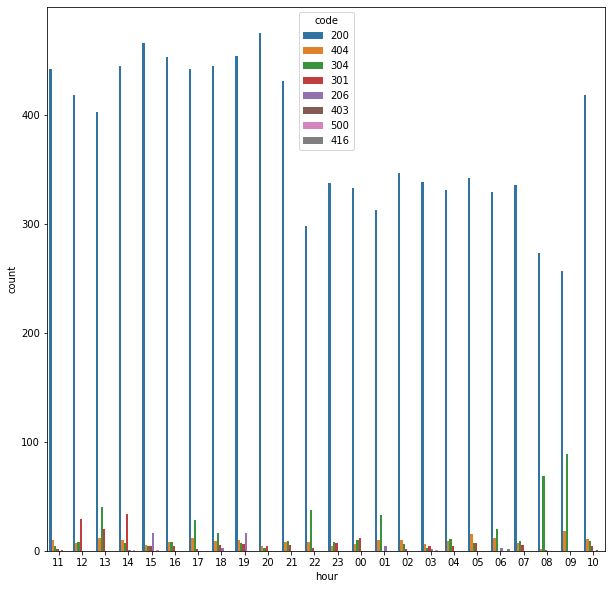

In [ ]:
plt.figure(figsize=[10, 10])
sns.barplot(data=df, x="hour", y="count", hue="code")

## Zad 3
Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.)

In [ ]:
file_regex = r'GET \S+\.(\w+) '

In [ ]:
def get_file_types(s):
  file_type = re.search(file_regex, s)
  return file_type.group(1) if file_type else 'other'

In [ ]:
files_types = lines.map(lambda s: (get_file_types(s), 1)) \
  .filter(lambda s: s[0] != 'other') \
  .reduceByKey(lambda a, b: a + b) \
  .sortBy(lambda s: -s[1]) \
  .collect()

In [ ]:
df = pd.DataFrame(files_types, columns=['File type', 'Count'])

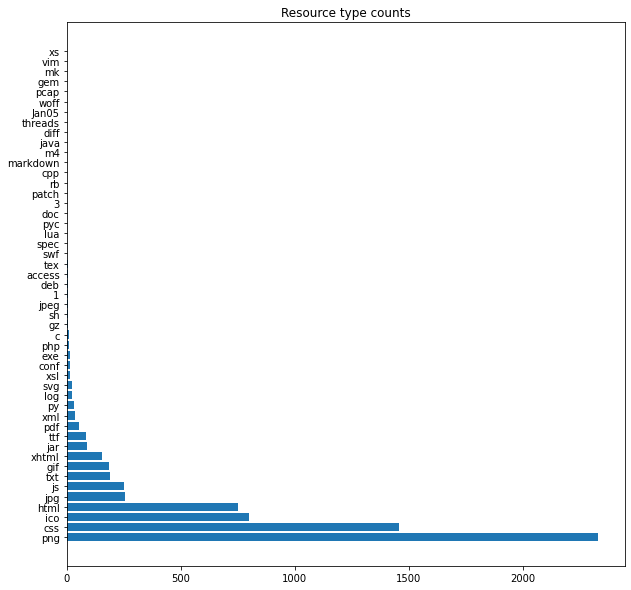

In [ ]:
plt.figure(figsize=[10, 10])
plt.barh(df['File type'], df['Count'])
plt.title("Resource type counts")
plt.show()

## Zad 4
Narysować mapę z lokalizacjami klientów

In [ ]:
# !pip3 install ipinfo
# !pip3 install cartopy

In [ ]:
import ipinfo
import cartopy
import re

In [ ]:
handler = ipinfo.getHandler(ipinfo_token)

In [ ]:
ip_regex = '([(\d\.)]+)'

In [ ]:
ips = lines.map(lambda s: re.match(ip_regex, s).group(0)) \
  .distinct() \
  .collect()

In [ ]:
infos = handler.getBatchDetails(ips)

In [ ]:
parsed_ips = [(ip, infos[ip]['latitude'], infos[ip]['longitude']) for ip in infos]

In [ ]:
lattitudes = [float(data[1]) for data in parsed_ips]
longitudes = [float(data[2]) for data in parsed_ips]

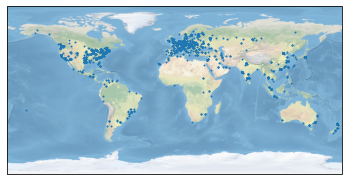

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(longitudes, lattitudes, s=1)
plt.show()

## Zad 5
Oszacować jaki procent ruchu generują boty

This was based on https://www.sumologic.com/insight/apache-logs-identifying-robots/

In [ ]:
all_actions = lines.count()

In [ ]:
good_bots = {"Googlebot", "AskJeeves", "Digger", "Lycos", "msnbot",
    "Inktomi Slurp", "Yahoo", "Nutch", "bingbot", "BingPreview",
    "Mediapartners-Google", "proximic", "AhrefsBot", "AdsBot-Google",
    "Ezooms", "AddThis.com", "facebookexternalhit", "MetaURI",
    "Feedfetcher-Google", "PaperLiBot", "TweetmemeBot", "Sogou web spider",
    "GoogleProducer", "RockmeltEmbedder", "ShareThisFetcher", "YandexBot",
    "rogerbot-crawler", "ShowyouBot", "Baiduspider", "Sosospider", "Exabot"
}

In [ ]:
good_bots_lines = lines.filter(lambda s: any(bot in s for bot in good_bots)) \
  .count()

In [ ]:
good_bot_actions = 100 * (good_bots_lines / all_actions)

In [ ]:
minute_regex = r'\[(\d+/\w+/\d+:\d+:\d+)'

This takes requests per minute. I take more than 20 site interactions/minute as a bot actions

In [ ]:
bot_actions = lines.map(lambda s: ((re.match(ip_regex, s).group(0), re.search(minute_regex, s).group(1)), 1)) \
  .reduceByKey(lambda a, b: a + b) \
  .sortBy(lambda s: -s[1]) \
  .filter(lambda s: s[1] > 20) \
  .map(lambda s: s[1]) \
  .reduce(lambda a, b: a + b)

In [ ]:
bot_perc = 100 * (bot_actions / all_actions)

In [ ]:
print(f'Estimated bot actions: {bot_perc:.2f}%')

Estimated bot actions: 21.31%


In [ ]:
print(f'Estimated good bot actions: {good_bot_actions:.2f}%')

Estimated good bot actions: 13.47%
